# Deploying a machine learning model to the web

Data scientists often have to communicate results to other people. In my case, my supervisors might want to see some numbers or I have to write up the main insights of some work for a paper. This is pretty straightforward - I just copy and paste into an email or a Latex document. But what if I want to send someone an actual model that I have trained, so that they can either evaluate or use it? If the person in question is technical enough, then I can just save the model to disk and email that, along with some Jupyter notebooks.

But what if you want someone in marketing to try out a model, or you want to share it with friends who might find it interesting? In this case, you'll need to make your code accessible to them in a way they are familiar with.

The three parts to this tutorial are:

1. Creating a simple model that can be deployed to the web, where users can input variables to get predictions.
2. Building the components needed by [Flask](http://flask.pocoo.org/) microframework to create a web app.
3. Deploying the final web app using the [Heroku](https://www.heroku.com/) platform.

The final product will look like this: http://bike-model.herokuapp.com/ - and if you know CSS (which I find much harder than machine learning, for some reason) then you could easily make it look a lot fancier!

There are a lot of tutorials for Flask online, but they can be a bit overwhelming and tend to focus on toy examples like a blog app or a to-do list, with many features we don't need. In this guide, the focus is on exactly the things you need in order to get your model up and running on the web as quickly as possible.

The model we will deploy is is based on [this CambridgeSpark tutorial](https://cambridgespark.com/content/tutorials/getting-started-with-xgboost/index.html), using the [xgboost](https://xgboost.readthedocs.io/en/latest/) package. Our model will perform regression on the data from [this tutorial](https://cambridgespark.com/content/tutorials/getting-started-with-regression-and-decision-trees/index.html), using three environmental variables (temperature, humidity, windspeed) to predict the number of bikes that will be rented out from a bike sharing scheme. However, you could deploy **any** model you like!

# Software requirements

Make sure you have the following installed if you want to copy and paste code from this page.

* Python 3.6+
* python packages (and versions used here):
    * flask==1.0.2
    * pandas==0.23.4
    * sklearn==0.19.2
    * xgboost==0.72.1
    * seaborn==0.9.0
    * matplotlib==2.2.2
    
You will also need to following tools installed.
* git
* the Heroku CLI

# Git repository

The final web app can be found on Github at https://github.com/alexanderrobertson/cambridgespark-webapp.

# Part 1 : Creating a model for deployment

The first thing we will need is a model. Did you know that [pandas](https://pandas.pydata.org/) can load data from a URL? No need to save to disk - pretty handy if you just want to quickly look at some data!

In [1]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/cambridgecoding/machinelearningregression/master/data/bikes.csv')

data.head(3)

,date,temperature,humidity,windspeed,count
0,2011-01-03,2.716070,45.715346,21.414957,120.0
1,2011-01-04,2.896673,54.267219,15.136882,108.0
2,2011-01-05,4.235654,45.697702,17.034578,82.0


## Pre-processing the data

The variable we want to predict is `count` and we'll do this using `temperature`, `humidity` and `windspeed`.

We won't use `date` for our prediction, but it might be useful for plotting. Let's convert it to a [datetime](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) object so that we can easily extract information from it, like the day of the week, month and year.

In [2]:
data['date'] = data['date'].apply(pd.to_datetime)

data['year'] = data['date'].apply(lambda date: date.year)
data['month'] = data['date'].apply(lambda date : date.month_name()[0:3])
data['day'] = data['date'].apply(lambda date: date.day_name()[0:3])

## Visualising the data
We can look quickly at the pattern of bike usage over time with some simple barplots. The information extracted earlier from the `date` column makes it easy to adjust granularity from days to months, as well as compare years.

It's also useful to quickly visualise the variables we are interested in. The [seaborn](https://seaborn.pydata.org/) package is great for this. A [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) will show the relationship between the target variable `count` and all other variables. By passing `kind='reg'` to the plotting function, a regression line can be fitted. This gives an indication of whether there might be a useful linear relation between variables.

It looks like there may be a good relationship between temperature and the number of bikes hired. But let's just use all the data for our model for now.

(Note: you will need the latest version of seaborn for the `pairplot` function used here.)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/alexander/anaconda3/envs/bell/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


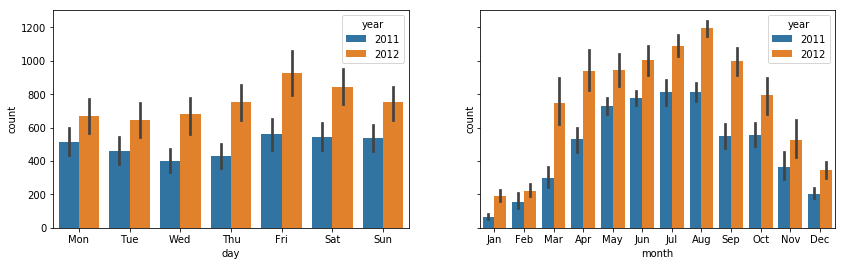

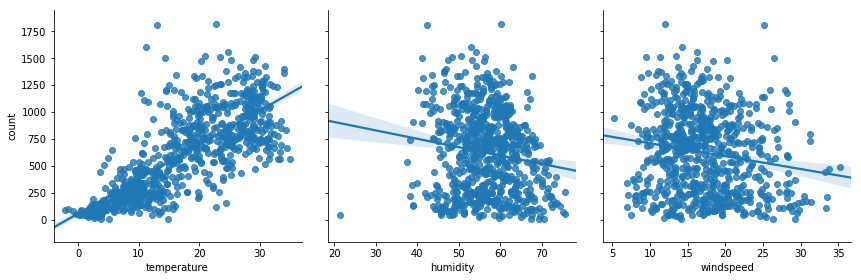

In [4]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=True)

bp1 = sns.barplot(data=data, x='day', y='count', hue='year', ax=ax1)
bp2 = sns.barplot(data=data, x='month', y='count', hue='year', ax=ax2)

pp = sns.pairplot(data=data,
                  y_vars=['count'],
                  x_vars=['temperature', 'humidity', 'windspeed'],
                  kind='reg',
                  height=4)

## Train the model

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

x = data[['temperature', 'humidity', 'windspeed']]
y = data['count']
         
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1)

## Evaluate the model

There are several intrinsic evaluation metrics for regression models. To see how our predictions match the true values, we can calculate [R<sup>2</sup>](https://en.wikipedia.org/wiki/Coefficient_of_determination), [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error) and the [Explained Variance](https://en.wikipedia.org/wiki/Explained_variation). Briefley, we want R<sup>2</sup> and EVS to be close to 1.0 and MAE to be close to 0. We can also plot predictions against truth in a [regression plot](https://seaborn.pydata.org/generated/seaborn.regplot.html), which will automatically fit a line for us.

(Note: if you aren't familiar with f-strings, which were introduced in Python 3.6 with [PEP 498](https://www.python.org/dev/peps/pep-0498/), take a look at [this](https://cito.github.io/blog/f-strings/) blog post for more details. They make it super easy to reference and format variables inside a string.)

In [6]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

R^2 score: 0.54
MAE score: 198.39
EVS score: 0.54


/home/alexander/anaconda3/envs/bell/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/alexander/anaconda3/envs/bell/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


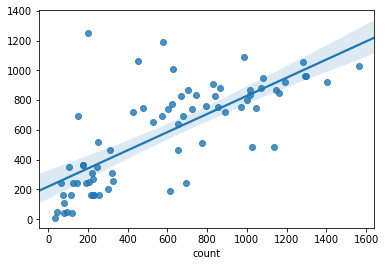

In [7]:
predictions = classifier.predict(X_test)

print(f'R^2 score: {r2_score(y_true=y_test, y_pred=predictions):.2f}')
print(f'MAE score: {mean_absolute_error(y_true=y_test, y_pred=predictions):.2f}')
print(f'EVS score: {explained_variance_score(y_true=y_test, y_pred=predictions):.2f}')

rp = sns.regplot(x=y_test, y=predictions)

## Getting the model ready for deployment

We can save our trained `classifier` model to disk using pickle. It can then be reloaded later on and used exactly as if we had trained it.

In [8]:
import pickle

with open('bike_model_xgboost.pkl', 'wb') as file:
    pickle.dump(classifier, file)

# Part 2: Creating a web app with Flask

There are several things we need to put together for the web app. The first two are:

1) The Python code that will load our model, get user input from a web form, do predictions, return results.
2) The HTML templates that flask with render. These allow the user to input their own data and will present the results.

The app will initially be structured like this:

~~~~
webapp/
    ├── model/
    │   └── bike_model_xgboost.pkl
    ├── templates/
    │   └── main.html
    └── app.py
~~~~

I'll first create extremely an basic `app.py` and `main.html`, to demonstrate how flask works. We will expand these later on to suit our needs.

## app.py

This is the core of your web app. It's what will run on the Heroku server, send out web pages and process input from users.

In flask, URLs get routed to different functions. Here, you can see that going to the base URL (e.g. www.cambridgespark.com) will trigger the `main()` function. This function simply serves up the `main.html` file, the location of which was specified when `app` was created. You can set up all sorts of routes for logging in, displaying data or similar.

~~~~python
import flask

app = flask.Flask(__name__, template_folder='templates')

@app.route('/')
def main():
    return(flask.render_template('main.html'))

if __name__ == '__main__':
    app.run()
~~~~

## main.html

This is what the template file looks like at the moment. All it does is display a simple message. We'll edit this later on to suit our needs. 

~~~~html
<!doctype html>

<html>
<head>
    
<title>Web app name</title>

</head>

<h1>Hello world.</h1>

</html>
~~~~

## Running the test app

To start up flask on your local machine, make sure you are in the `webapp` folder and run the command:

~~~~bash
flask run
~~~~

This will launch your app locally, at http://127.0.0.1:5000/. It should look something like this:

![Basic example app running](notebook_images/webappexample.png)

It's really easy to turn this basic example into an app that will let people input values for temperature, humidity and windspeed, and get a predicted value for the number of bikes being rented. The changes we need to make are:

1. Edit app.py to load the model
2. Expand `main()` to prompt for user input, retrieve user input, make predictions and return predictions.
3. Edit main.html to have a form that gets the input we need, allows users to submit input and renders predictions.

## Editing app.py to load the model

Below you can see the extended app.py. With a pickled model, we don't need to import xgboost or anything - we just assign it to a variable - but we do need to have the required packages installed. Notice that we load the model at the top of the app. This means it will only get loaded into memory once on the server when we deploy it, rather than being loaded every time we want to make a prediction.

~~~~python
import flask
import pickle

# Use pickle to load in the pre-trained model.
with open(f'model/bike_model_xgboost.pkl', 'rb') as f:
    model = pickle.load(f)

app = flask.Flask(__name__, template_folder='templates')

@app.route('/')
def main():
    return(flask.render_template('main.html'))

if __name__ == '__main__':
    app.run()
~~~~

## Expanding the main() function

Our app will run in two modes. In one, it will be displaying the input form to the user. In the other, it will be retrieving that input. This uses two different [HTTP methods](https://www.w3schools.com/tags/ref_httpmethods.asp): `GET` and `POST`.

If a user loads the main URL for the app (e.g. http://myapp.herokuapp.com/), flask will receive a `GET` request and render `main.html`.

If the user fills in the form on the page and clicks on a submit button, flask receives a `POST` request, extracts the input, runs it through the model and will finally render `main.html` with the results in place. The user can then view that result and submit more data for processing.

Flask extracts the data from the form with the `flask.request.form` functionality, which works like a dictionary. We can grab the data we want from the form by referring it to the name. This name will be set in the `main.html` template, later on.

Once we have our three variables, the classifier needs them in an expected format. I've used a pandas DataFrame here, because it allows us to specify the order of the columns and their datatype. It's important to make sure these are `float`, since the model expects these rather than `int`.

Passing all this to the model for prediction returns a single item inside an array, which can be extracted by indexing it.

Finally, the function renders the `main.html` template but now it also returns two variables: the original input and the result. These will be explained in the changes that are needed for `main.html`.

~~~~python
@app.route('/', methods=['GET', 'POST'])
def main():
    if flask.request.method == 'GET':
        return(flask.render_template('main.html'))
    
    if flask.request.method == 'POST':

        temperature = flask.request.form['temperature']
        humidity = flask.request.form['humidity']
        windspeed = flask.request.form['windspeed']

        input_variables = pd.DataFrame([[temperature, humidity, windspeed]],
                                       columns=['temperature', 'humidity', 'windspeed'],
                                       dtype=float)

        prediction = model.predict(input_variables)[0]
    
        return flask.render_template('main.html',
                                     original_input={'Temperature':temperature,
                                                     'Humidity':humidity,
                                                     'Windspeed':windspeed},
                                     result=prediction,
                                     )
~~~~

## Editing the main.html template

The template needs expanded with a form, plus a way of determining if results need to be rendered and, if so, to render them. The HTML code for this is below.

Important components:

### The form
~~~~html
<form action="{{ url_for('main') }}" method="POST">
~~~~

The `action` attribute tells flask which route (and therefore function) should be called when the form is submitted. In this simple app, we just want the main function. The `POST` method tells that function that it should expect input and therefore process it.

### Some input checks

Flask takes care of [sanitising user input](http://flask.pocoo.org/docs/0.12/security/#cross-site-scripting-xss) so that it does not contain potential security risks. However, we also need to consider whether a user might make a mistake. When we are working with our own models, we don't tend to do things like randomly bash the keyboard to put in data. But you'd be surprised what other people do... So, it's best to make sure the input is what you expect e.g. text or numbers. Therefore, the `<input>` elements of the form have the `required` attribute, to make them compulsory.


###  The results div

~~~~html
<div class="result" align="center">
    {% if result %}
    	{% for variable, value in original_input.items() %}
    		<b>{{ variable }}</b> : {{ value }}
    	{% endfor %}
		<br>
    	<br> Predicted number of bikes in use:
   		<p style="font-size:50px">{{ result }}</p>
    {% endif %}
</div>
~~~~
This part of the template uses special syntax to render Python variables. It loops through the items in the `original_input` dictionary and also prints the `result`. This is how we get the data out of our model and onto the web, where the user can actually see it. The form also makes sure the user inputs numbers, not text.

### Minimal CSS for appearance

Some CSS is defined in the header, under `<style>`, to place the inputs in the middle of the page.

~~~~html
<!doctype html>
<html>
<style>
form {
    margin: auto;
    width: 35%;
}

.result {
    margin: auto;
    width: 35%;
    border: 1px solid #ccc;
}
</style>

<head>
    <title>Bike Usage Model</title>
</head>
<form action="{{ url_for('main') }}" method="POST">
    <fieldset>
        <legend>Input values:</legend>
        Temperature:
        <input name="temperature" type="number" required>
        <br>
        <br> Humidity:
        <input name="humidity" type="number" required>
        <br>
        <br> Windspeed:
        <input name="windspeed" type="number" required>
        <br>
        <br>
        <input type="submit">
    </fieldset>
</form>
<br>
<div class="result" align="center">
    {% if result %}
    	{% for variable, value in original_input.items() %}
    		<b>{{ variable }}</b> : {{ value }}
    	{% endfor %}
		<br>
    	<br> Predicted number of bikes in use:
   		<p style="font-size:50px">{{ result }}</p>
    {% endif %}
</div>

</html>
~~~~

# Part 3: Ready for deployment!

At this point, you have a functioning web app running on your local machine. However, it is hard to share this - your machine might be behind a firewall, your IP address might change often or the machine isn't always on. Luckily, it's possible to deploy flask apps to an online platform that will make it much easier for people to access your app.

Heroku has good documentation [online](https://devcenter.heroku.com/articles/getting-started-with-python) but I'll outline the minimum things you need to do for the current task.

1. Sign up for a free Heroku account at https://signup.heroku.com/signup/dc
2. Make sure you have [git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git) installed, to push your app to Heroku.
3. Install the [Heroku CLI tool](https://devcenter.heroku.com/articles/heroku-cli#download-and-install).


## Make a git repository for your web app

Inside the `webapp` folder, run the following to create a new repository.

~~~~bash
git init
~~~~

## Authenticate with Heroku

Once this is done, you can log into your Heroku account using the CLI

~~~~bash
heroku login
~~~~

## Create a new Heroku app

~~~~bash
heroku create
~~~~

By default, this will make an app with a random name. If you want to choose your own name, simply pass it as an argument. For example:

~~~~bash
heroku create bike-model
~~~~
![Basic example app running](notebook_images/herokucreate.png)


## Create the required Heroku files

You will need two files, placed inside the `webapp` folder.

1. `requirements.txt` - this tells Heroku which packages to install for your web app. It should look like this:

~~~~
flask
pandas
gunicorn
xgboost
~~~~

2. `Procfile` - this tells Heroku what kind of app you are running and how to serve it to users. It is a single line and should look like this:

~~~~
web: gunicorn app:app
~~~~

Your web app folder should now look like this:

~~~~
webapp/
    ├── model/
    │   └── bike_model_xgboost.pkl
    ├── templates/
    │   └── main.html
    ├── requirements.txt
    ├── Procfile
    └── app.py
~~~~

## Add files to repository

While in the `webapp` folder, use the following command to add all your web app's files to the git repository:

~~~~bash
git add .
git commit -m "First commit!"
~~~~

![Basic example app running](notebook_images/gitcommit.png)

## Set the remote destination for pushing from git to Heroku

This command makes it easier to push your local web app to Heroku, using git. You should change `bike-model` to whatever you named your Heroku app when you created it.

~~~~bash
heroku git:remote -a bike-model
~~~~

![Basic example app running](notebook_images/gitremote.png)


## Push your app to the web

Just one more command and your web app will be online. During this process, Heroku will upload your app files, install the packages it needs and start the app running.

~~~~bash
git push heroku master
~~~~

If everything goes as expected, you'll see output showing things being installed and uploaded. 

## Check out the deployed app!

You can use the `heroku open` command to open your completed app in the web browser. Alternatively, just go to http://bike-model.herokuapp.com (replacing `bike-model` with your app's name, of course). You can share that link with whoever you want to see your model.

# Summary

By this point, you have used flask and Heroku to deploy a simple machine learning model to the web, where it can be accessed by people you want to share your work with.

# Extending this work

Now that you're familiar with the basics, you might want to think about how you can improve upon what has been done here.

* Use CSS to make the web app look a bit less 1990s - look at [Bootstrap](https://getbootstrap.com/) for making pretty layouts, forms and buttons. 

* Extend the number of models available on the app - we only trained one model on all the variables, but how would you go about making it possible for a user to select a model trained on particular variables?

* Change what the model predicts - at the moment, it predicts the number of bikes in use, but could it be used to predict the month of the year? How would your `main.html` template change to accomodate this? And what changes would need to be made to the `main()` function in `app.py`?

* Do you want to restrict access to your model? Take a look at [Flask-login](https://flask-login.readthedocs.io/en/latest/) and see if you can implement user authentication.

* Maybe you want to improve the model? Take a look at this guide to [hyperparameter tuning in xgboost](https://cambridgespark.com/content/tutorials/hyperparameter-tuning-in-xgboost/index.html).